<a href="https://colab.research.google.com/github/rdgnoleto/Machine_Learning_DIO/blob/main/deteccao_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Instalando o tesorflow no ambiente
!pip install mtcnn tensorflow opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 54.4 MB/s eta 0:00:00


In [23]:
# Instalando a fonte "DejaVu Sans" para garantir personalização de resultados
!apt-get install -y fonts-dejavu-core

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-dejavu-core is already the newest version (2.37-2build1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [24]:
import cv2  # leitura, escrita e manipulação de imagens
import numpy as np  # manipulação de arrays e matrizes
from mtcnn.mtcnn import MTCNN  # detector de rostos baseado em redes neurais
from PIL import Image  # manipulação de imagens (redimensionar, salvar e desenhar sobre imagens)
import os  # interações com o sistema de arquivos (listar pastas, criar diretórios, montar caminhos)
import matplotlib.pyplot as plt  # criar e exibir de imagens

In [25]:
# descompactando a pasta de dados
import zipfile

with zipfile.ZipFile("rostos.zip", 'r') as zip_ref:
    zip_ref.extractall()

In [26]:
# Criando o objeto detector usando o modelo MTCNN (Multi-task Cascaded Convolutional Networks)
detector = MTCNN()

# função que recebe as imagens, detecta os rostos, os recorta e os salvam em uma nova pasta de nome rostos_recortados
def detectar_e_salvar_rostos(pasta_origem="rostos", pasta_destino="rostos_recortados"):
    if not os.path.exists(pasta_destino):
        os.makedirs(pasta_destino)

    pessoas = os.listdir(pasta_origem)
    for pessoa in pessoas:
        caminho_pessoa = os.path.join(pasta_origem, pessoa)
        if not os.path.isdir(caminho_pessoa):
            continue

        destino_pessoa = os.path.join(pasta_destino, pessoa)
        os.makedirs(destino_pessoa, exist_ok=True)

        for imagem_nome in os.listdir(caminho_pessoa):
            caminho_imagem = os.path.join(caminho_pessoa, imagem_nome)
            img = cv2.imread(caminho_imagem)
            if img is None:
                print(f"Erro ao ler {caminho_imagem}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            faces = detector.detect_faces(img_rgb)

            if not faces:
                print(f"Nenhum rosto detectado em {caminho_imagem}")
                continue

            for i, face in enumerate(faces):
                x, y, w, h = face['box']
                x, y = max(0, x), max(0, y)
                rosto = img_rgb[y:y+h, x:x+w]
                rosto_pil = Image.fromarray(rosto).resize((160, 160))
                nome_arquivo = f"{os.path.splitext(imagem_nome)[0]}_face{i}.jpg"
                caminho_salvar = os.path.join(destino_pessoa, nome_arquivo)
                rosto_pil.save(caminho_salvar)
                print(f"Salvo: {caminho_salvar}")

In [27]:
detectar_e_salvar_rostos()

Salvo: rostos_recortados/chaves/6_face0.jpg
Salvo: rostos_recortados/chaves/3_face0.jpg
Salvo: rostos_recortados/chaves/8_face0.jpg
Salvo: rostos_recortados/chaves/10_face0.jpg
Salvo: rostos_recortados/chaves/7_face0.jpg
Salvo: rostos_recortados/chaves/1_face0.jpg
Salvo: rostos_recortados/chaves/4_face0.jpg
Salvo: rostos_recortados/chaves/9_face0.jpg
Salvo: rostos_recortados/chaves/2_face0.jpg
Salvo: rostos_recortados/chaves/5_face0.jpg
Salvo: rostos_recortados/madruga/6_face0.jpg
Salvo: rostos_recortados/madruga/3_face0.jpg
Salvo: rostos_recortados/madruga/4_face0.jpg
Salvo: rostos_recortados/madruga/10_face0.jpg
Salvo: rostos_recortados/madruga/7_face0.jpg
Salvo: rostos_recortados/madruga/1_face0.jpg
Salvo: rostos_recortados/madruga/9_face0.jpg
Salvo: rostos_recortados/madruga/8_face0.jpg
Salvo: rostos_recortados/madruga/2_face0.jpg
Salvo: rostos_recortados/madruga/5_face0.jpg
Salvo: rostos_recortados/quico/6_face0.jpg
Salvo: rostos_recortados/quico/3_face0.jpg
Salvo: rostos_recortad

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Gera lotes de imagens com aumento e pré-processamento dinâmico durante o treinamento
from tensorflow.keras.models import Sequential                      # Modelo sequencial linear para construir redes neurais camada por camada
from tensorflow.keras.layers import Dense, Flatten                   # Camadas densas (totalmente conectadas) e camada para "achatar" tensores multidimensionais
from tensorflow.keras.optimizers import Adam                         # Otimizador Adam para ajustar pesos da rede durante o treinamento

In [29]:
# Usando data augmentation para aumentar a base de dados manipulando as imagens do dataset em diferentes rotações
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

In [30]:
# Gerador de imagens para o conjunto de treinamento
# Aplica data augmentation e carrega 80% das imagens da pasta 'rostos_recortados/'
train_generator = datagen.flow_from_directory(
    'rostos_recortados/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',  # Codificação one-hot para múltiplas classes
    subset='training'          # Define que é o subconjunto de treino
)

# Gerador de imagens para o conjunto de validação
# Usa os 20% restantes das imagens, sem sobrepor com as do treinamento
validation_generator = datagen.flow_from_directory(
    'rostos_recortados/',
    target_size=(160, 160),
    batch_size=32,
    class_mode='categorical',  # Mesmo formato do treino
    subset='validation'        # Define que é o subconjunto de validação
)

Found 24 images belonging to 3 classes.
Found 6 images belonging to 3 classes.


In [31]:
class_names = list(train_generator.class_indices.keys())

# Obtém automaticamente o número de classes (pastas) a partir dos dados de treino
num_classes = len(train_generator.class_indices)

# Criação do modelo sequencial com três camadas
model = Sequential([
    Flatten(input_shape=(160, 160, 3)),  # Camada Flatten: transforma a imagem (160x160x3) em um vetor 1D (linear)
    Dense(128, activation='relu'), # Camada oculta totalmente conectada com 128 neurônios e função de ativação ReLU
    Dense(num_classes, activation='softmax') # Camada de saída com um neurônio para cada classe e ativação softmax (distribuição de probabilidade)
])

In [32]:
# Configura o modelo para treinamento
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [37]:
# Treina o modelo usando os dados de treino e validação por 50 épocas, armazenando o histórico do treinamento na variável 'history'
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50
)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step - accuracy: 0.7083 - loss: 2.1987 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.8333 - loss: 2.0091 - val_accuracy: 0.5000 - val_loss: 2.5108
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8750 - loss: 0.8784 - val_accuracy: 1.0000 - val_loss: 0.0186
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step - accuracy: 0.7500 - loss: 2.5525 - val_accuracy: 1.0000 - val_loss: 0.1238
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step - accuracy: 0.7500 - loss: 2.4255 - val_accuracy: 0.8333 - val_loss: 2.6497
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step - accuracy: 0.8333 - loss: 1.1364 - val_accuracy: 0.8333 - val_loss: 0.6433
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step - accuracy: 0.9583 - loss: 0.2600 - val_accuracy: 0.8333 - val_loss: 1.0653
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - accuracy: 0.8750 - loss: 0.9439 - val_accuracy: 0.6667 - val_loss:

In [34]:
# importando um arquivo para teste
from google.colab import files
uploaded = files.upload()

Saving teste.jpg to teste (1).jpg


In [35]:
from PIL import ImageDraw, ImageFont # Importa módulos para desenhar e escrever texto sobre imagens usando PIL (Python Imaging Library)

# Função para mostrar a imagem de teste antes da detecção
def mostrar(img_np, titulo="Imagem"):
    plt.figure(figsize=(8,8))
    plt.imshow(img_np)
    plt.axis('off')
    plt.title(titulo)
    plt.show()

# Função para realizar a detecção
def reconhecer_e_desenhar_caixas(model, class_names, caminho_imagem):
    img_pil = Image.open(caminho_imagem).convert('RGB')
    img_rgb = np.array(img_pil)

    mostrar(img_rgb, "Imagem Original")

    faces = detector.detect_faces(img_rgb)
    if not faces:
        print("Nenhuma face detectada.")
        return

    draw = ImageDraw.Draw(img_pil)
    font_path = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
    try:
        font = ImageFont.truetype(font_path, 20)
    except:
        font = ImageFont.load_default()

    for face in faces:
        x, y, w, h = face['box']
        x, y = max(0, x), max(0, y)
        rosto = img_rgb[y:y+h, x:x+w]
        rosto_pil = Image.fromarray(rosto).resize((160, 160))
        rosto_arr = np.array(rosto_pil) / 255.0
        rosto_arr = np.expand_dims(rosto_arr, axis=0)

        pred = model.predict(rosto_arr, verbose=0)
        idx = np.argmax(pred)
        nome = class_names[idx]
        confianca = pred[0][idx]

        texto = f"{nome} ({confianca*100:.1f}%)"

        draw.rectangle([(x, y), (x + w, y + h)], outline="blue", width=4)

        bbox = draw.textbbox((x, y), texto, font=font)
        draw.rectangle([bbox[0], bbox[1], bbox[2], bbox[3]], fill="blue")
        draw.text((bbox[0], bbox[1]), texto, fill="white", font=font)

    mostrar(np.array(img_pil), "Faces Reconhecidas")
class_names = list(train_generator.class_indices.keys())

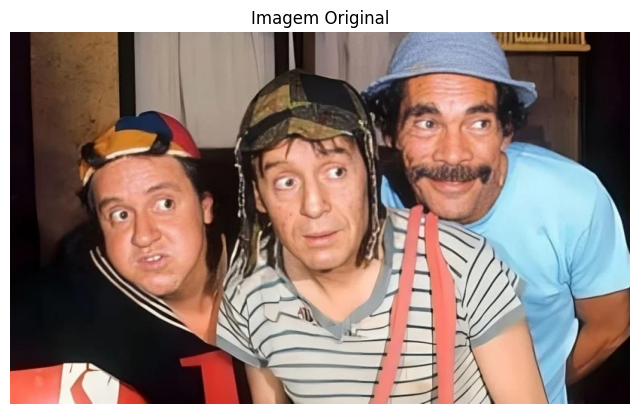

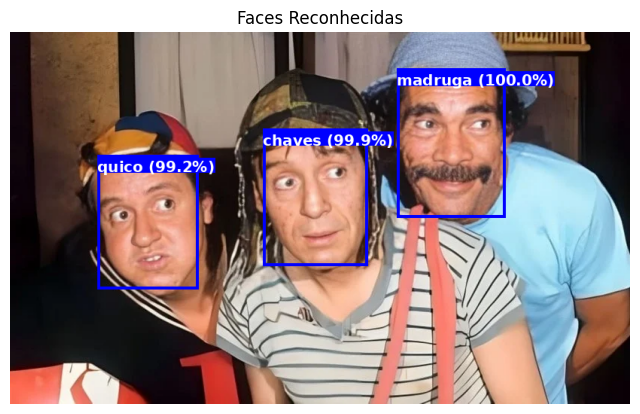

In [40]:
reconhecer_e_desenhar_caixas(model, class_names, "teste.jpg")